In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


c:\Users\cgross\Anaconda3\envs\pmrid2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


prepare data

In [2]:
df_neg = pd.read_csv('data\\neg_A0201.txt', header=None)
df_pos = pd.read_csv('data\\pos_A0201.txt', header=None)

amino_acids = sorted(list(set(list("".join(df_neg[0])))))

In [3]:
# Create a mapping from amino acid to index
amino_acid_to_index = {amino_acid: idx for idx, amino_acid in enumerate(amino_acids)}

# Function to one-hot encode a single 9-mer peptide
def one_hot_encode_peptide(peptide):
    # Initialize a 9x20 matrix of zeros
    one_hot = np.zeros((9, 20), dtype=int)
    for i, aa in enumerate(peptide):
        # Set the appropriate position to 1
        one_hot[i, amino_acid_to_index[aa]] = 1
    # Flatten the matrix into a 180-dimensional vector
    return one_hot.flatten()

In [4]:
df_neg['one_hot'] = df_neg[0].apply(one_hot_encode_peptide)
df_pos['one_hot'] = df_pos[0].apply(one_hot_encode_peptide)

X_neg = torch.tensor(df_neg['one_hot'])   
y_neg = torch.zeros(X_neg.shape[0])

X_pos = torch.tensor(df_pos['one_hot'])
y_pos = torch.ones(X_pos.shape[0])

X = torch.cat([X_neg, X_pos], dim=0).to(torch.float)
y = torch.cat([y_neg, y_pos], dim=0).to(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# class_weights = torch.tensor([len(y_train) / sum(y_train == 0), len(y_train) / sum(y_train == 1)], dtype=torch.float) 

C:\Users\cgross\AppData\Local\Temp\ipykernel_29968\3636799831.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  X_neg = torch.tensor(df_neg['one_hot'])


create and train MLP

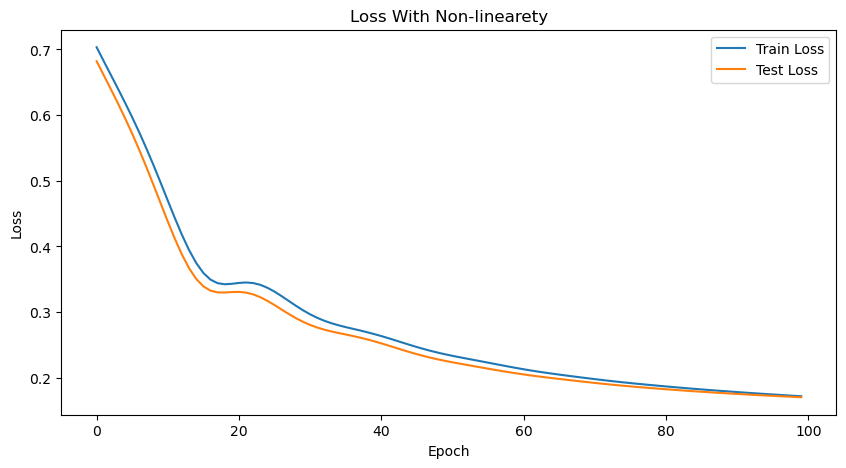

In [5]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Assuming `X_train`, `y_train`, `X_test`, and `y_test` are already prepared
input_dim = 180
model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch} \ {num_epochs}", end='\r')
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        test_losses.append(test_loss.item())

# Plotting the train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss With Non-linearety")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


mlp without Non linearity

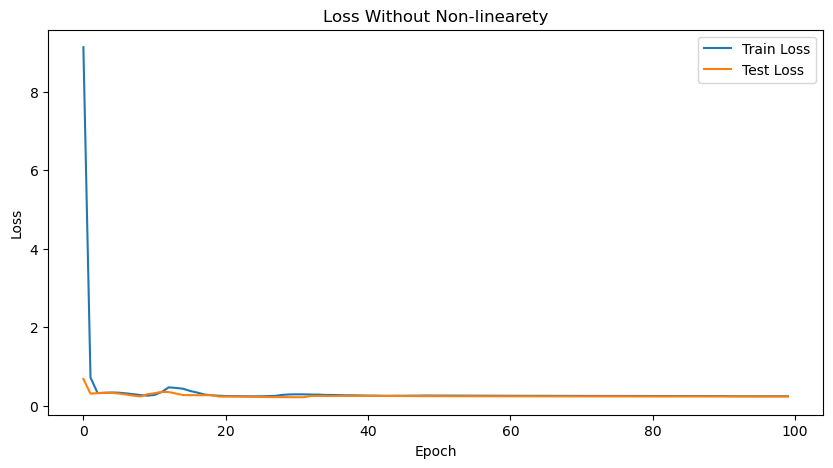

In [7]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.fc3 = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # return torch.sigmoid(x)
        return torch.clamp(x, 0, 1)

# Assuming `X_train`, `y_train`, `X_test`, and `y_test` are already prepared
input_dim = 180
model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch} \ {num_epochs}", end='\r')
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs.squeeze(), y_test)
        test_losses.append(test_loss.item())

# Plotting the train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss Without Non-linearety")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
